In [73]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [19]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
import yfinance as yf
dataSPY = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "SPY",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "10y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # Whether to ignore timezone when aligning ticker data from 
        # different timezones. Default is True. False may be useful for 
        # minute/hourly data.
        ignore_tz = False,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # identify and attempt repair of currency unit mixups e.g. $/cents
        repair = False,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )['Close']
dataStocks = []
for stock in ['AAPL', 'MSFT']:

  dataStocks.append(
        yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = stock,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "10y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # Whether to ignore timezone when aligning ticker data from 
        # different timezones. Default is True. False may be useful for 
        # minute/hourly data.
        ignore_tz = False,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # identify and attempt repair of currency unit mixups e.g. $/cents
        repair = False,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )['Close']
  )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
dataStocks = np.transpose(dataStocks) #reorder so 0th dimension is time, 1st dimension is features
print(f"Stocks data shape: {np.shape(dataStocks)}")
print(f"SPY data shape: {np.shape(dataSPY)}")

Stocks data shape: (2519, 2)
SPY data shape: (2519,)


In [47]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [83]:
import tensorflow as tf
import yfinance as yf
from sklearn.model_selection import train_test_split

#Helper function to generate input data of appropriate shape
def generate_time_series_data(data, batch_size):
  # Generate batches of data
  num_samples = data.shape[0]
  num_batches = num_samples // batch_size
  batchSet = []
  for i in range(num_batches):
    batchSet.append(data[i * batch_size:(i + 1) * batch_size])
  return np.asarray(batchSet)

#set the hyperparameters
batch_size = 128
latent_dim = 32
learning_rate = 1e-1
num_epochs = 1000
beta = 0.005 #information bottleneck coefficient

#Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(dataStocks, dataSPY, test_size=0.2)
x_train = generate_time_series_data(x_train, batch_size)
x_test = generate_time_series_data(x_test, batch_size)
y_train = generate_time_series_data(y_train, batch_size)
y_test = generate_time_series_data(y_test, batch_size)
print(f"shapes 1: {np.shape(x_train)} and {np.shape(y_train)}")
#Reshape the data to be 3D [samples, timesteps, features]
# x_train = x_train.reshape((-1, 1, 1))
# x_test = x_test.reshape(-1, 1, 1)

#Build the model
print(f"test: {x_train.shape[1]} and {x_train.shape[2]}")

inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
lstm_encoder = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = lstm_encoder(inputs)
encoder_states = [state_h, state_c]

z_mean = tf.keras.layers.Dense(latent_dim)(encoder_outputs)
z_log_var = tf.keras.layers.Dense(latent_dim)(encoder_outputs)

def sampling(args):
  z_mean, z_log_var = args
  epsilon = tf.random.normal(shape=tf.shape(z_mean))
  return z_mean + tf.exp(0.5*z_log_var)*epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

lstm_decoder = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = lstm_decoder(z, initial_state=encoder_states)
print(f"shapes 2: {np.shape(inputs)} and {np.shape(decoder_outputs)}")
decoder_outputs=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_outputs)
decoder_outputs=tf.squeeze(decoder_outputs, axis=[2]) #This fixes dimensionality issue (does it break anything?)
print(f"shapes 2: {np.shape(inputs)} and {np.shape(decoder_outputs)}")

#Define the loss
def IBLoss(inputs, decoder_outputs):
  print(f"inputs: {inputs}")
  print(f"{decoder_outputs}")
  print(f"shapes 3: {np.shape(inputs)} and {np.shape(decoder_outputs)}")
  
  reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, decoder_outputs)
  kl_loss = -0.5*tf.reduce_mean(z_log_var - tf.square(z_mean)-tf.exp(z_log_var) + 1)
  information_bottleneck_loss = beta*kl_loss
  loss = reconstruction_loss + information_bottleneck_loss
  print(f"shapes 4: {np.shape(loss)}")
  return loss

#Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
print(decoder_outputs)
print(inputs)
#Compile the model
model = tf.keras.Model(inputs, decoder_outputs)
model.compile(optimizer=optimizer, loss=IBLoss)

#Train the model
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs)

#Evaluate the model
test_loss = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}')

shapes 1: (15, 128, 2) and (15, 128)
test: 128 and 2
shapes 2: (None, 128, 2) and (None, 128, 32)
shapes 2: (None, 128, 2) and (None, 128)
Tensor("Squeeze_6:0", shape=(None, 128), dtype=float32)
Tensor("input_40:0", shape=(None, 128, 2), dtype=float32)
inputs: Tensor("tf_op_layer_Squeeze_6_target:0", shape=(None, None), dtype=float32)
Tensor("Squeeze_6:0", shape=(None, 128), dtype=float32)
shapes 3: (None, None) and (None, 128)
shapes 4: ()
Train on 15 samples
Epoch 1/1000
15/15 [==============================] - 9s 606ms/sample - loss: 73254.5469
Epoch 2/1000
15/15 [==============================] - 0s 6ms/sample - loss: 71018.9609
Epoch 3/1000
15/15 [==============================] - 0s 6ms/sample - loss: 69394.9844
Epoch 4/1000
15/15 [==============================] - 0s 6ms/sample - loss: 68321.0703
Epoch 5/1000
15/15 [==============================] - 0s 6ms/sample - loss: 67271.3984
Epoch 6/1000
15/15 [==============================] - 0s 6ms/sample - loss: 66216.3750
Epoch 7/100

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  


Test loss: 9407.3603515625


Merging with Xinyi's code

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import math
import numpy as np
import statistics as stats
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

#Helper function to generate input data of appropriate shape
def generate_time_series_data(data, batch_size):
  # Generate batches of data
  num_samples = data.shape[0]
  num_batches = num_samples // batch_size
  batchSet = []
  for i in range(num_batches):
    batchSet.append(data[i * batch_size:(i + 1) * batch_size])
  return np.asarray(batchSet)

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append(tf.timestamp() - self.timetaken)
        self.epochs.append(epoch)
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(self.epochs, self.times, 'ro')
        for i in range(len(self.epochs)):
          j = self.times[i].numpy()
          if i == 0:
            plt.text(i, j, str(round(j, 3)))
          else:
            j_prev = self.times[i-1].numpy()
            plt.text(i, j, str(round(j-j_prev, 3)))
        plt.savefig(datetime.now().strftime("%Y%m%d%H%M%S") + ".png")

In [7]:
#Load data and create portfolios
Portfolio_tickers = ['AVGO', 'COST', 'FDS', 'FTNT', 'ORLY', 'REGN', 'TMO', 'TSLA', 'UNH']
Long_tickers = ['CPB', 'K']
Portfolio = yf.download(Portfolio_tickers, start='2021-05-03', end='2022-07-12')['Adj Close']
Long = yf.download(Long_tickers, start='2021-05-03', end='2022-07-12')['Adj Close']
CPB = Long[['CPB']]
K = Long[['K']]
Portfolio1 = pd.concat([Portfolio, CPB], axis=1)
Portfolio2 = pd.concat([Portfolio, K], axis=1)
Portfolio3 = pd.concat([Portfolio, Long], axis=1)

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  2 of 2 completed


In [8]:
batch_size = 60

#Data preprocessing
training_data_len = math.ceil(len(Portfolio3)* 0.8)
temp = []
tickers = Portfolio3.columns.values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(Portfolio3)
data = scaled_data.reshape(-1,11)
print(f"data shape: {data.shape}")

#Training data
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(batch_size, len(train_data)):
    x_train.append(train_data[i-batch_size:i, :])
    y_train.append(train_data[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
print(f"train_data shape: {train_data.shape}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

#Test data
test_data = scaled_data[training_data_len-batch_size: , : ]
y_test = data[training_data_len:]
x_test = []

for i in range(batch_size, len(test_data)):
  x_test.append(test_data[i-batch_size:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

print(f"test data shape: {test_data.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

data shape: (300, 11)
train_data shape: (240, 11)
x_train shape: (180, 60, 11)
y_train shape: (180, 11)
test data shape: (120, 11)
x_test shape: (60, 60, 11)
y_test shape: (60, 11)


In [12]:
#set the hyperparameters
latent_dim = 32
learning_rate = 1e-2
num_epochs = 10
beta = 1 #information bottleneck coefficient
n_stocks = np.shape(x_train)[2]

#Build the model
inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
lstm_encoder = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = lstm_encoder(inputs)
encoder_states = [state_h, state_c]

z_mean = tf.keras.layers.Dense(latent_dim)(encoder_outputs)
z_log_var = tf.keras.layers.Dense(latent_dim)(encoder_outputs)

def sampling(args):
  z_mean, z_log_var = args
  epsilon = tf.random.normal(shape=tf.shape(z_mean))
  return z_mean + tf.exp(0.5*z_log_var)*epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

lstm_decoder = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = lstm_decoder(z, initial_state=encoder_states)
decoder_outputs=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_stocks))(decoder_outputs)

#Define the losses for IB and no-IB
def IBLoss(inputs, decoder_outputs):
  reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, decoder_outputs)
  kl_loss = -0.5*tf.reduce_mean(z_log_var - tf.square(z_mean)-tf.exp(z_log_var) + 1)
  information_bottleneck_loss = beta*kl_loss
  loss = reconstruction_loss + information_bottleneck_loss
  return loss

def MSELoss(inputs, decoder_outputs):
  reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, decoder_outputs)
  return reconstruction_loss

#Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#Compile the model
model = tf.keras.Model(inputs, decoder_outputs)
model.compile(optimizer=optimizer, loss=IBLoss)

model2 = tf.keras.Model(inputs, decoder_outputs)
model2.compile(optimizer=optimizer, loss=MSELoss)

# test_loss = model.evaluate(x_test, y_test)
# print(f'Test loss: {test_loss}')

In [30]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16080761550965785557
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12119195825351907165
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [31]:
#GPU mode
#Train the model
modelStart = datetime.now()
model.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
modelEnd = datetime.now()
print(f"model 1 wall clock time: {modelEnd-modelStart}")
modelStart2 = datetime.now()
model2.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
modelEnd2 = datetime.now()
print(f"model 1 wall clock time: {modelEnd2-modelStart2}")

#Evaluate the model
predictions = np.mean(model.predict(x_test), axis=0)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)

predictions2 = np.mean(model2.predict(x_test), axis=0)
predictions2 = scaler.inverse_transform(predictions2)
rmse2 = np.sqrt(np.mean(predictions2 - y_test)**2)

print(f"IB rmse: {rmse}")
print(f"no IB rmse: {rmse2}")

Train on 180 samples
Epoch 1/10
180/180 [==============================] - 19s 103ms/sample - loss: 0.0064
Epoch 2/10
180/180 [==============================] - 19s 104ms/sample - loss: 0.0065
Epoch 3/10
180/180 [==============================] - 19s 103ms/sample - loss: 0.0070
Epoch 4/10
180/180 [==============================] - 19s 105ms/sample - loss: 0.0063
Epoch 5/10
180/180 [==============================] - 19s 103ms/sample - loss: 0.0065
Epoch 6/10
180/180 [==============================] - 19s 104ms/sample - loss: 0.0059
Epoch 7/10
180/180 [==============================] - 18s 102ms/sample - loss: 0.0061
Epoch 8/10
180/180 [==============================] - 19s 103ms/sample - loss: 0.0060
Epoch 9/10
180/180 [==============================] - 19s 103ms/sample - loss: 0.0059
Epoch 10/10
180/180 [==============================] - 19s 103ms/sample - loss: 0.0056
model 1 wall clock time: 0:03:06.060966
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 37s

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 367.23024755016235
no IB rmse: 367.1228968366059


In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2185597978877016199
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 40231960576
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5886719758418751024
 physical_device_desc: "device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [11]:
#GPU mode
#Train the model
modelStart_2 = datetime.now()
model.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
modelEnd_2 = datetime.now()
print(f"model 1 wall clock time: {modelEnd_2-modelStart_2}")
modelStart2_2 = datetime.now()
model2.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
modelEnd2_2 = datetime.now()
print(f"model 1 wall clock time: {modelEnd2_2-modelStart2_2}")

#Evaluate the model
predictions = np.mean(model.predict(x_test), axis=0)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)

predictions2 = np.mean(model2.predict(x_test), axis=0)
predictions2 = scaler.inverse_transform(predictions2)
rmse2 = np.sqrt(np.mean(predictions2 - y_test)**2)

print(f"IB rmse: {rmse}")
print(f"no IB rmse: {rmse2}")

Train on 180 samples
Epoch 1/10
180/180 [==============================] - 19s 82ms/sample - loss: 0.0487
Epoch 2/10
180/180 [==============================] - 15s 81ms/sample - loss: 0.0277
Epoch 3/10
180/180 [==============================] - 15s 82ms/sample - loss: 0.0199
Epoch 4/10
180/180 [==============================] - 15s 82ms/sample - loss: 0.0203
Epoch 5/10
180/180 [==============================] - 15s 82ms/sample - loss: 0.0279
Epoch 6/10
180/180 [==============================] - 15s 82ms/sample - loss: 0.0182
Epoch 7/10
180/180 [==============================] - 15s 82ms/sample - loss: 0.0157
Epoch 8/10
180/180 [==============================] - 15s 81ms/sample - loss: 0.0130
Epoch 9/10
180/180 [==============================] - 15s 81ms/sample - loss: 0.0105
Epoch 10/10
180/180 [==============================] - 15s 81ms/sample - loss: 0.0096
model 1 wall clock time: 0:02:31.591236
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 34s 188ms/sam

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 376.9056872936421
no IB rmse: 377.0957973673097


In [21]:
#TPU
import os
try:
 device_name = os.environ["COLAB_TPU_ADDR"]
 TPU_ADDRESS = "grpc://" + device_name
 print("Found TPU at: {}".format(TPU_ADDRESS))
except KeyError:
 print("TPU not found")

Found TPU at: grpc://10.48.20.114:8470


In [13]:
#TPU mode
#Train the model
modelStart_2 = datetime.now()
model.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
modelEnd_2 = datetime.now()
print(f"model 1 wall clock time: {modelEnd_2-modelStart_2}")
modelStart2_2 = datetime.now()
model2.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
modelEnd2_2 = datetime.now()
print(f"model 1 wall clock time: {modelEnd2_2-modelStart2_2}")

#Evaluate the model
predictions = np.mean(model.predict(x_test), axis=0)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)

predictions2 = np.mean(model2.predict(x_test), axis=0)
predictions2 = scaler.inverse_transform(predictions2)
rmse2 = np.sqrt(np.mean(predictions2 - y_test)**2)

print(f"IB rmse: {rmse}")
print(f"no IB rmse: {rmse2}")

Train on 180 samples
Epoch 1/10
180/180 [==============================] - 7s 34ms/sample - loss: 0.0543
Epoch 2/10
180/180 [==============================] - 6s 32ms/sample - loss: 0.0386
Epoch 3/10
180/180 [==============================] - 6s 34ms/sample - loss: 0.0342
Epoch 4/10
180/180 [==============================] - 7s 40ms/sample - loss: 0.0269
Epoch 5/10
180/180 [==============================] - 6s 34ms/sample - loss: 0.0256
Epoch 6/10
180/180 [==============================] - 6s 34ms/sample - loss: 0.0267
Epoch 7/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0211
Epoch 8/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0197
Epoch 9/10
180/180 [==============================] - 6s 34ms/sample - loss: 0.0195
Epoch 10/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0180
model 1 wall clock time: 0:01:04.604386
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 14s 69ms/sample - loss:

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 381.8121098570966
no IB rmse: 381.084415195407


In [31]:
#Information Bottleneck Hyperparameter Search
betaIB = [0.05, 0.1, 0.5,1, 1.5, 2, 2.5]
rmseDict = {}
for beta2 in betaIB:
  #set the hyperparameters
  latent_dim = 32
  learning_rate = 1e-2
  num_epochs = 10
  n_stocks = np.shape(x_train)[2]

  #Build the model
  inputs = tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2]))
  lstm_encoder = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
  encoder_outputs, state_h, state_c = lstm_encoder(inputs)
  encoder_states = [state_h, state_c]

  z_mean = tf.keras.layers.Dense(latent_dim)(encoder_outputs)
  z_log_var = tf.keras.layers.Dense(latent_dim)(encoder_outputs)

  def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5*z_log_var)*epsilon

  z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

  lstm_decoder = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = lstm_decoder(z, initial_state=encoder_states)
  decoder_outputs=tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_stocks))(decoder_outputs)

  #Define the losses for IB and no-IB
  def IBLoss(inputs, decoder_outputs):
    reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, decoder_outputs)
    kl_loss = -0.5*tf.reduce_mean(z_log_var - tf.square(z_mean)-tf.exp(z_log_var) + 1)
    information_bottleneck_loss = beta2*kl_loss
    loss = reconstruction_loss + information_bottleneck_loss
    return loss

  def MSELoss(inputs, decoder_outputs):
    reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, decoder_outputs)
    return reconstruction_loss

  #Define the optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  #Compile the model
  model = tf.keras.Model(inputs, decoder_outputs)
  model.compile(optimizer=optimizer, loss=IBLoss)

  model2 = tf.keras.Model(inputs, decoder_outputs)
  model2.compile(optimizer=optimizer, loss=MSELoss)

  # test_loss = model.evaluate(x_test, y_test)
  # print(f'Test loss: {test_loss}')

  #Train the model
  print(f"beta2: {beta2}")
  modelStart_2 = datetime.now()
  model.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
  modelEnd_2 = datetime.now()
  print(f"model 1 wall clock time: {modelEnd_2-modelStart_2}")
  modelStart2_2 = datetime.now()
  model2.fit(x_train, y_train, batch_size=1, epochs=num_epochs)
  modelEnd2_2 = datetime.now()
  print(f"model 1 wall clock time: {modelEnd2_2-modelStart2_2}")

  #Evaluate the model
  predictions = np.mean(model.predict(x_test), axis=0)
  predictions = scaler.inverse_transform(predictions)
  rmse = np.sqrt(np.mean(predictions - y_test)**2)

  predictions2 = np.mean(model2.predict(x_test), axis=0)
  predictions2 = scaler.inverse_transform(predictions2)
  rmse2 = np.sqrt(np.mean(predictions2 - y_test)**2)

  print(f"IB rmse: {rmse}")
  print(f"no IB rmse: {rmse2}")
  rmseDict["IB_beta2"+str(beta2)] = rmse
  rmseDict["noIB_beta2"+str(beta2)] = rmse2

beta2: 0.05
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 16s 37ms/sample - loss: 0.0417
Epoch 2/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0227
Epoch 3/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0180
Epoch 4/10
180/180 [==============================] - 7s 36ms/sample - loss: 0.0185
Epoch 5/10
180/180 [==============================] - 8s 42ms/sample - loss: 0.0185
Epoch 6/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0135
Epoch 7/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0131
Epoch 8/10
180/180 [==============================] - 6s 34ms/sample - loss: 0.0116
Epoch 9/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0106
Epoch 10/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0103
model 1 wall clock time: 0:01:16.568388
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 18s 72ms/s

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 387.64229893198853
no IB rmse: 387.56168227577183
beta2: 0.1
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 16s 38ms/sample - loss: 0.0423
Epoch 2/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0255
Epoch 3/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0238
Epoch 4/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0200
Epoch 5/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0192
Epoch 6/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0179
Epoch 7/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0184
Epoch 8/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0158
Epoch 9/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0120
Epoch 10/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0105
model 1 wall clock time: 0:01:15.893461
Train on 180 samples
Epoch 

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 377.59492364600186
no IB rmse: 377.425346902847
beta2: 0.5
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 18s 39ms/sample - loss: 0.0641
Epoch 2/10
180/180 [==============================] - 7s 40ms/sample - loss: 0.0282
Epoch 3/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0232
Epoch 4/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0217
Epoch 5/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0178
Epoch 6/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0182
Epoch 7/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0214
Epoch 8/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0156
Epoch 9/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0179
Epoch 10/10
180/180 [==============================] - 6s 34ms/sample - loss: 0.0151
model 1 wall clock time: 0:01:18.478911
Train on 180 samples
Epoch 1/

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 387.0544991603618
no IB rmse: 387.12334515779645
beta2: 1
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 18s 39ms/sample - loss: 0.0501
Epoch 2/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0293
Epoch 3/10
180/180 [==============================] - 6s 35ms/sample - loss: 0.0253
Epoch 4/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0221
Epoch 5/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0244
Epoch 6/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0163
Epoch 7/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0153
Epoch 8/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0149
Epoch 9/10
180/180 [==============================] - 7s 36ms/sample - loss: 0.0135
Epoch 10/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0142
model 1 wall clock time: 0:01:17.686456
Train on 180 samples
Epoch 1/1

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 379.5553608946942
no IB rmse: 379.545185715704
beta2: 1.5
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 19s 38ms/sample - loss: 0.0462
Epoch 2/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0325
Epoch 3/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0233
Epoch 4/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0186
Epoch 5/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0186
Epoch 6/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0185
Epoch 7/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0183
Epoch 8/10
180/180 [==============================] - 7s 36ms/sample - loss: 0.0180
Epoch 9/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0172
Epoch 10/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0163
model 1 wall clock time: 0:01:19.995295
Train on 180 samples
Epoch 1/1

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 390.2098199290071
no IB rmse: 389.9545787777176
beta2: 2
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 22s 43ms/sample - loss: 0.0515
Epoch 2/10
180/180 [==============================] - 7s 41ms/sample - loss: 0.0340
Epoch 3/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0300
Epoch 4/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0208
Epoch 5/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0171
Epoch 6/10
180/180 [==============================] - 7s 39ms/sample - loss: 0.0143
Epoch 7/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0139
Epoch 8/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0117
Epoch 9/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0112
Epoch 10/10
180/180 [==============================] - 7s 39ms/sample - loss: 0.0104
model 1 wall clock time: 0:01:24.144399
Train on 180 samples
Epoch 1/10

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 374.10538375397863
no IB rmse: 374.01742367258913
beta2: 2.5
Train on 180 samples
Epoch 1/10
180/180 [==============================] - 19s 37ms/sample - loss: 0.0484
Epoch 2/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0404
Epoch 3/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0251
Epoch 4/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0204
Epoch 5/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0194
Epoch 6/10
180/180 [==============================] - 6s 36ms/sample - loss: 0.0180
Epoch 7/10
180/180 [==============================] - 7s 37ms/sample - loss: 0.0175
Epoch 8/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0175
Epoch 9/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0174
Epoch 10/10
180/180 [==============================] - 7s 38ms/sample - loss: 0.0176
model 1 wall clock time: 0:01:20.051136
Train on 180 samples
Epoch 

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IB rmse: 376.51793688808766
no IB rmse: 376.56695984586054


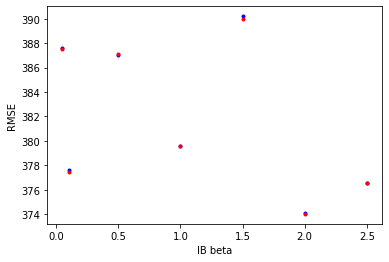

In [46]:
for ele in list(rmseDict.keys()):
  model = ele.split("_")[0]
  if model == "IB":
    plt.plot(float(ele.split('beta2')[1]), rmseDict[ele], 'b.', label='IB')
  elif model == "noIB":
    plt.plot(float(ele.split('beta2')[1]), rmseDict[ele], 'r.', label='MSE')
  plt.xlabel("IB beta")
  plt.ylabel("RMSE")
  # print(rmseDict[ele])
  # plt.plot(float(ele.split('beta2')[1]), rmseDict[ele], 'b.')


In [109]:
def calcSharpe(port):
  mu = expected_returns.capm_return(port)
  Sigma = risk_models.CovarianceShrinkage(port).ledoit_wolf()

  ef = EfficientFrontier(mu, Sigma)
  ef.max_sharpe()
  weights = ef.clean_weights()

  portfolio_mean = 0
  portfolio_var = 0

  for ticker in weights.keys():
      portfolio_mean += weights[ticker]*mu[ticker]

  for ticker1 in weights.keys():
      for ticker2 in weights.keys():
          portfolio_var += weights[ticker1]*weights[ticker2]*sigma[ticker1][ticker2]

  portfolio_std = portfolio_var ** (1/2)

  portfolio_sharpe = portfolio_mean/portfolio_std
  return portfolio_sharpe

In [ ]:
calcSharpe()

In [ ]:
print(f"Sharpe Ratios\nPortfolio 1: {calcSharpe(Port1)}\nPortfolio 2: {calcSharpe(Port2)}\nPortfolio 3: {calcSharpe(Port3)}")